## Test custom Architecture Implementation

On Random input tensor

In [ ]:
from custom_yolov5s import YOLOV5S
import config
import time
import torch
from PIL import Image

# SET UP:
batch_size = 1
image_height = 640
image_width = 640
n_classes = 80
c2 = 32
channels = (c2*4, c2*8, c2*16)
anchors = config.ANCHORS

# sample input
x = torch.rand(batch_size, 3, image_width, image_height)  

# model
model = YOLOV5S(c2=c2, n_classes=n_classes, anchors=anchors, channels=channels)

# time taken to forward pass
start = time.time()
out = model(x)
end = time.time()

assert out[0].shape == (batch_size, 3, image_height//8, image_width//8, n_classes + 5)
assert out[1].shape == (batch_size, 3, image_height//16, image_width//16, n_classes + 5)
assert out[2].shape == (batch_size, 3, image_height//32, image_width//32, n_classes + 5)

print("Success!")
print("feedforward took {:.2f} seconds".format(end - start))
print("\n")
print("shape of output: \n",out[0].shape,"\n", out[1].shape,"\n", out[2].shape,"\n")

Success!
feedforward took 0.17 seconds


shape of output: 
 torch.Size([1, 3, 80, 80, 85]) 
 torch.Size([1, 3, 40, 40, 85]) 
 torch.Size([1, 3, 20, 20, 85]) 



## Visualization of Feature Maps

In [9]:
import matplotlib.pyplot as plt
import torch

def visualize_yolo_feature_maps(output_tensor, title="", n_channels=3, anchor_idx=0, batch_idx=0):
    """
    Visualizes channels from YOLOv5 detection head output.
    
    Args:
        output_tensor: Tensor of shape [batch, anchors, grid_h, grid_w, (5 + nc)]
        title: Plot title
        n_channels: Number of channels to visualize
        anchor_idx: Which anchor to visualize (0 to 2)
        batch_idx: Which batch item to visualize
    """
    # Detach and select first batch item and anchor
    if output_tensor.requires_grad:
        features = output_tensor.detach()[batch_idx, anchor_idx]  # [grid_h, grid_w, 85]
    else:
        features = output_tensor[batch_idx, anchor_idx]  # [grid_h, grid_w, 85]
    
    # Create subplots
    fig, axes = plt.subplots(1, n_channels, figsize=(15, 5))
    if n_channels == 1:
        axes = [axes]  # Ensure axes is always iterable
    
    # Visualize first n_channels of the 85-dimension
    for i in range(n_channels):
        channel_data = features[:, :, i].cpu().numpy()
        axes[i].imshow(channel_data, cmap='plasma')
        axes[i].set_title(f"Channel {i}")
        axes[i].axis('off')
    
    plt.suptitle(f"{title} (Grid {features.shape[0]}x{features.shape[1]})")
    plt.tight_layout()
    plt.show()

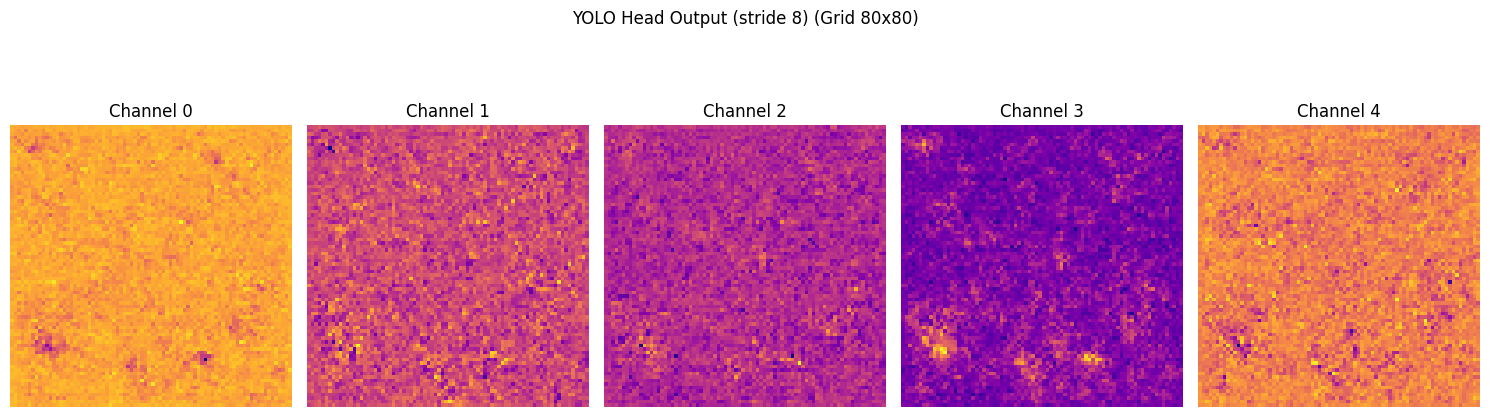

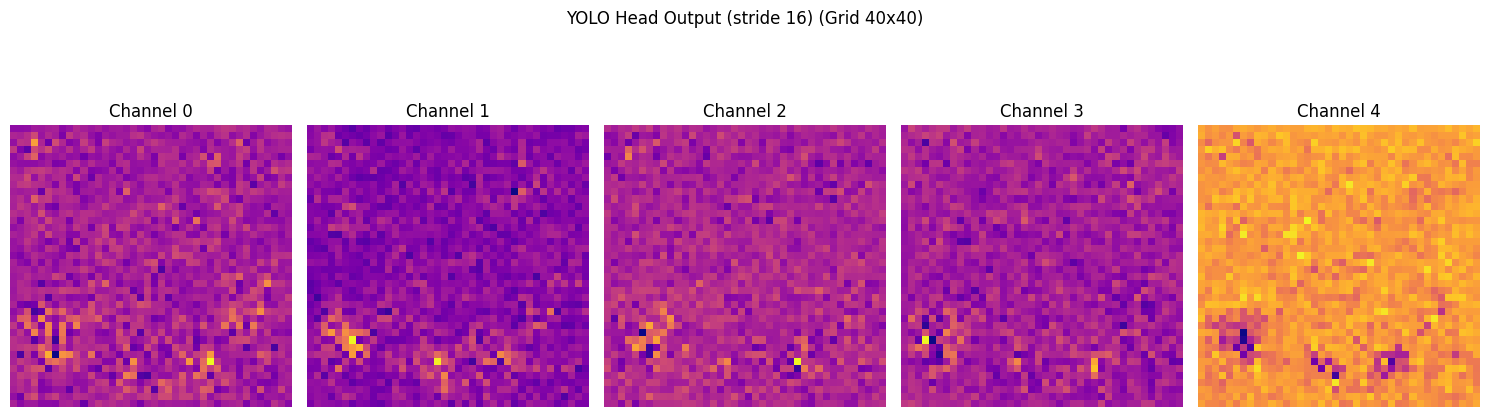

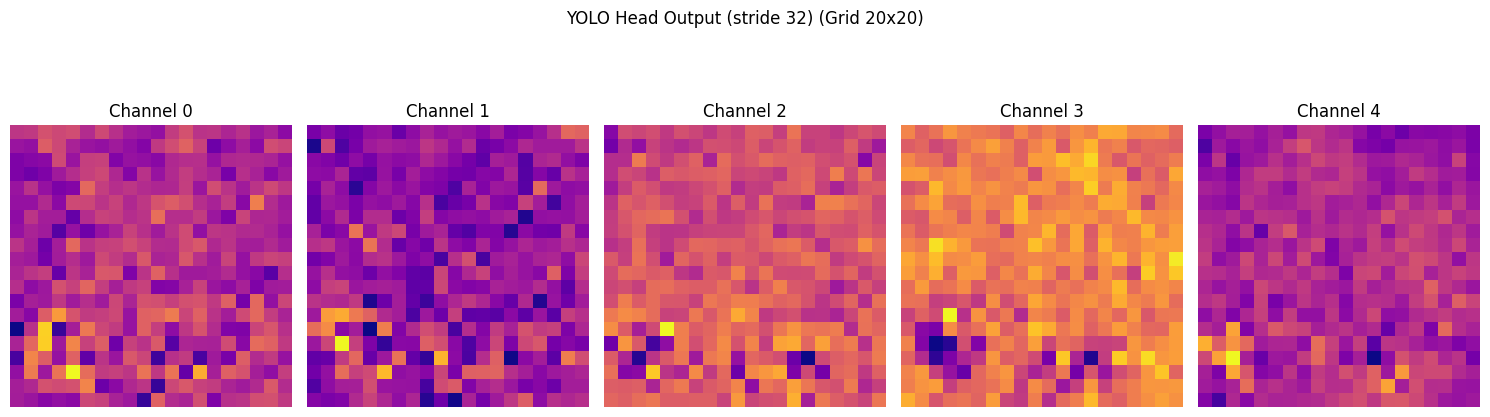

In [10]:
# plot the first channel feature maps
# Example usage with your model outputs
for i, out in enumerate(out):  # model_outputs is list of 3 detection levels
    stride = 8 * (2 ** i)  # 8, 16, 32
    visualize_yolo_feature_maps(
        out, 
        title=f"YOLO Head Output (stride {stride})",
        n_channels=5,  # Show first 5 channels (tx, ty, tw, th, obj)
        anchor_idx=0   # Show first anchor
    )

## Test on Real world images - forward pass through the model

Prepare the image

In [11]:
import torchvision.transforms as T

def prepare_image_for_yolov5(image_path, target_size=640):
    """
    Prepares an image for YOLOv5 detection head.
    
    Args:
        image_path: Path to the input image (JPG/PNG/etc)
        target_size: Size to resize to (YOLOv5 typically uses 640x640)
        
    Returns:
        torch.Tensor of shape (1, 3, target_size, target_size) - ready for model
        original_image: PIL Image for visualization
        image_ratio: (w_ratio, h_ratio) for mapping predictions back to original
    """
    # Open and validate image
    original_image = Image.open(image_path).convert('RGB')
    img_width, img_height = original_image.size
    
    # Calculate ratios for later rescaling
    w_ratio = target_size / img_width
    h_ratio = target_size / img_height
    
    # Create transformation pipeline
    transform = T.Compose([
        T.Resize((target_size, target_size)),  # Maintains aspect ratio if needed
        T.ToTensor(),                          # Converts to [0,1] range
        #T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                   #std=[0.229, 0.224, 0.225])
    ])
    
    # Apply transformations and add batch dimension
    image_tensor = transform(original_image).unsqueeze(0)  # (1, 3, H, W)
    
    return image_tensor, original_image, (w_ratio, h_ratio)

In [12]:
image_tensor, _, _, = prepare_image_for_yolov5(image_path="C:\\Users\\kruth\\yolov5_from_scratch\\sample_images\\moni1.jpg")
print(image_tensor.shape)

torch.Size([1, 3, 640, 640])


(-0.5, 639.5, 639.5, -0.5)

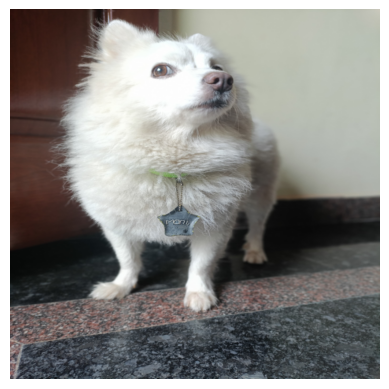

In [13]:
# show input image
plt.imshow(image_tensor.squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')


Outputs

Success!
feedforward took 0.16 seconds


shape of output: 
 torch.Size([1, 3, 80, 80, 85]) 
 torch.Size([1, 3, 40, 40, 85]) 
 torch.Size([1, 3, 20, 20, 85]) 



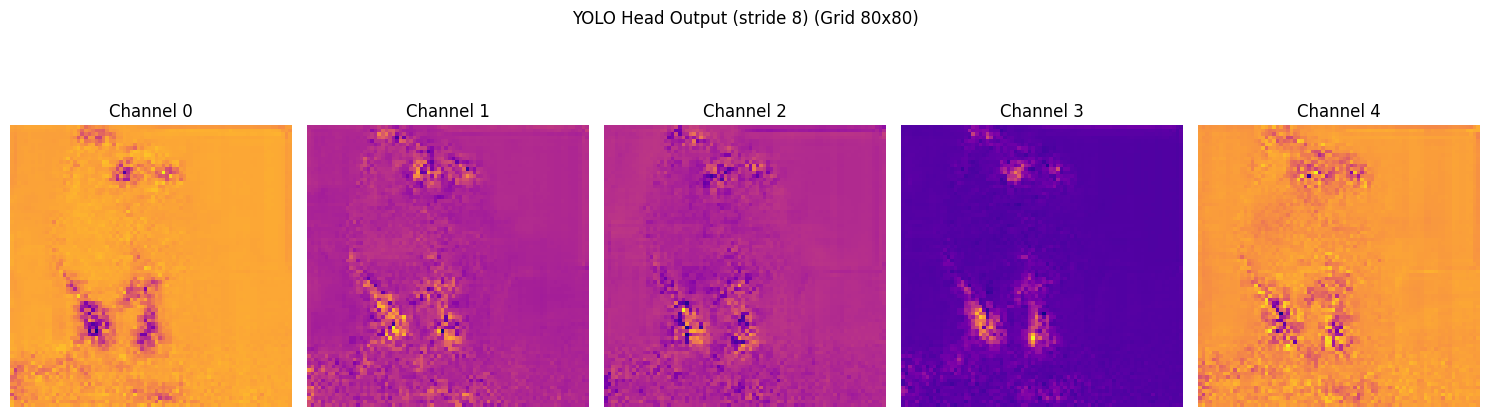

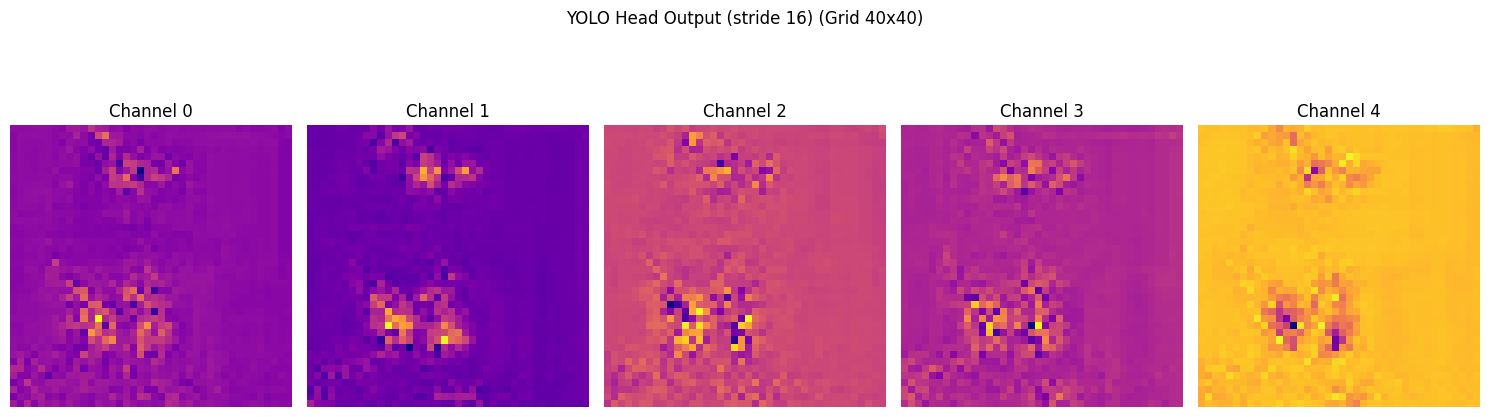

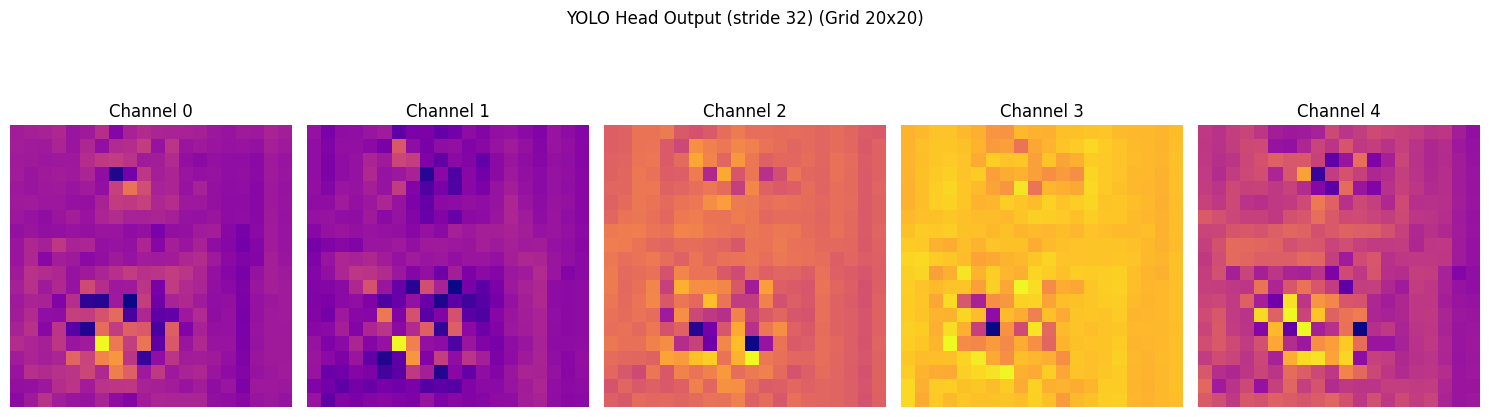

In [14]:
# time taken to forward pass
start = time.time()
out_image = model(image_tensor)
end = time.time()

print("Success!")
print("feedforward took {:.2f} seconds".format(end - start))
print("\n")
print("shape of output: \n",out_image[0].shape,"\n", out_image[1].shape,"\n", out_image[2].shape,"\n")
# plot the first channel feature maps
# Example usage with your model outputs
for i, out_image in enumerate(out_image):  # model_outputs is list of 3 detection levels
    stride = 8 * (2 ** i)  # 8, 16, 32
    visualize_yolo_feature_maps(
        out_image, 
        title=f"YOLO Head Output (stride {stride})",
        n_channels=5,  # Show first 5 channels (tx, ty, tw, th, obj)
        anchor_idx=0   # Show first anchor
    )

In [ ]:
# export the model to onnx

# export to ONNX
torch.onnx.export(model, 
                x, 
                "custom_yolov5s.onnx", 
                opset_version=11,
                #do_constant_folding=False, #prevent folding of batch norm into conv,
                input_names=['input'],
                output_names=['output'],
)

c:\Users\kruth\yolov5_from_scratch\custom_yolov5s.py:374: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert x.shape[2] % 32 == 0 and x.shape[3] % 32 == 0
